# 센서 데이터 클러스터링 분석

이 노트북은 CO₂, 온도, 습도 데이터를 전처리하고 KMeans 클러스터링을 수행한 뒤, 도메인 검증을 위한 절차를 담고 있습니다.

## 1) 라이브러리 임포트 및 폰트 설정

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.font_manager as fm
import matplotlib as mpl
import seaborn as sns

font_path = "/System/Library/Fonts/Supplemental/AppleGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)
font_name = fontprop.get_name()
mpl.rcParams['font.family'] = font_name
mpl.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
plt.rcParams['font.family'] = font_name


## 2) 데이터 로드 및 전처리

In [11]:
df = pd.read_csv("./sensor_data_pivot.csv", parse_dates=['time'])
df.head()

,time,location,co2,humidity,temperature
0,2025-04-25 00:05:00+00:00,8인 책상,481.400000,25.6,23.660000
1,2025-04-25 00:05:00+00:00,보드,562.000000,41.5,23.600000
2,2025-04-25 00:05:00+00:00,왼쪽 뒤,556.000000,35.0,23.166667
3,2025-04-25 00:10:00+00:00,8인 책상,491.800000,26.6,23.780000
4,2025-04-25 00:10:00+00:00,보드,550.333333,41.5,23.533333


## area 매핑 및 파생 변수 생성

In [12]:
area_map = {
    "8인 책상": 64.65,
    "왼쪽 뒤": 109.21,
    "안쪽벽 중앙": 25.13,
    "보드": 31.59
}
df['area'] = df['location'].map(area_map)
df = df.dropna(subset=['area'])
df['co2_per_area'] = df['co2'] / df['area']

## 결측치 처리

In [13]:
imputer = IterativeImputer(random_state=42)
df[['co2', 'temperature', 'humidity']] = imputer.fit_transform(
    df[['co2', 'temperature', 'humidity']]
)
df = df.dropna(subset=['co2_per_area'])

In [14]:
df.isna().sum()

time            0
location        0
co2             0
humidity        0
temperature     0
area            0
co2_per_area    0
dtype: int64

## 데이터 증강

In [15]:
def gen_proto(n, mean, std, areas):
    df_s = pd.DataFrame({
        'co2': np.random.normal(mean[0], std[0], n),
        'temperature': np.random.normal(mean[1], std[1], n),
        'humidity': np.random.normal(mean[2], std[2], n),
    })
    df_s['co2_per_area'] = df_s['co2'] / np.random.choice(areas, n)
    return df_s

areas = df['area'].unique()
specs = [
    ([850, 19, 35], [200, 1, 5]),   # 춥고 건조
    ([1200, 27, 65], [300, 1, 5])   # 덥고 습함
]
synth = pd.concat([gen_proto(2000, m, s, areas) for m, s in specs], ignore_index=True)
df = pd.concat([df, synth], ignore_index=True)


In [17]:
# 불필요 컬럼 제거
df = df.drop(columns=['time', 'location', 'area'])


KeyError: "['time', 'location', 'area'] not found in axis"

## 이상치 제거

In [18]:
for col in ['temperature', 'humidity', 'co2_per_area']:
    lo, hi = df[col].quantile([0.01, 0.99])
    df[col] = df[col].clip(lo, hi)


## 특성 행렬 구성 및 스케일링

In [19]:
features = ['co2', 'temperature', 'humidity', 'co2_per_area']
X = df[features].copy()
scaler = StandardScaler()
X = scaler.fit_transform(X)

## 3) KMeans 클러스터링 및 최적 k 탐색 (엘보우)

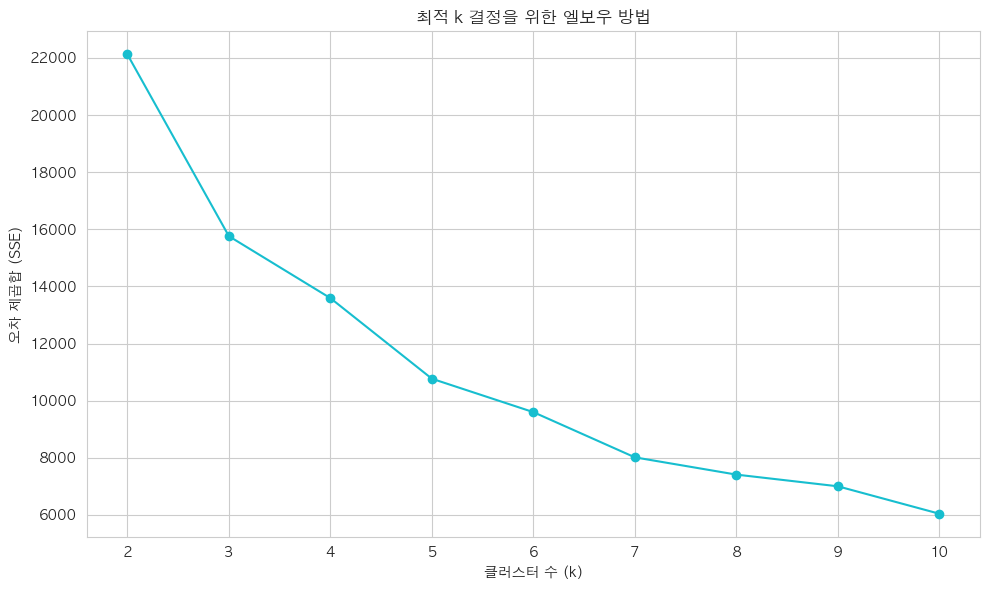

In [20]:
Ks = range(2, 11)
sse = []
for k in Ks:
    km = KMeans(n_clusters=k, init='k-means++', random_state=42, algorithm="elkan")
    km.fit(X)
    sse.append(km.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(Ks, sse, marker='o', color='#17becf')
plt.xlabel('클러스터 수 (k)')
plt.ylabel('오차 제곱합 (SSE)')
plt.title('최적 k 결정을 위한 엘보우 방법')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4) 최적 k=3로 클러스터링 및 평가

In [21]:
k_opt = 3
km = KMeans(n_clusters=k_opt, init='k-means++', random_state=42, algorithm="elkan")
labels = km.fit_predict(X)
df['cluster'] = labels

## 클러스터 중심 복원


In [23]:
centers_orig = scaler.inverse_transform(km.cluster_centers_)
centers = pd.DataFrame(centers_orig, columns=features)

## 실루엣 스코어 출력

In [25]:
sil_score = silhouette_score(X, labels)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.4313582633622034


# PCA 시각화

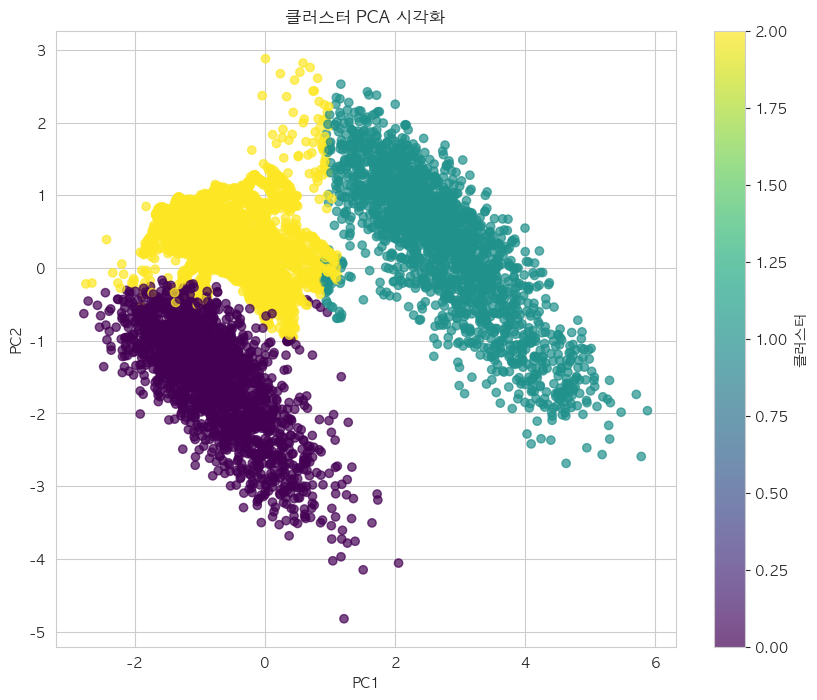

In [26]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', alpha=0.7)
plt.title('클러스터 PCA 시각화')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='클러스터')
plt.show()

## 5) 도메인 검증

In [27]:
# CO2 상태 컬럼
df['co2_status'] = np.where(df['co2'] > 1000, 'CO2 주의', 'CO2 양호')

# 검증용 피처
check_feats = ['co2', 'temperature', 'humidity', 'co2_per_area']

# 라벨 매핑
mapping = {0: '춥고 건조', 1: '덥고 습함', 2: '최적 쾌적'}
df['cluster_label'] = df['cluster'].map(mapping)

# 검증용 피처 리스트
check_feats = ['co2','temperature','humidity','co2_per_area']

# 클러스터별 요약 통계
print("=== 클러스터별 요약 통계 ===")
print(df.groupby('cluster_label')[check_feats].agg(['mean','min','max','std']))


=== 클러스터별 요약 통계 ===
                       co2                                      temperature  \
                      mean         min          max         std        mean   
cluster_label                                                                 
덥고 습함          1223.429036  497.964215  2342.883959  278.472915   26.906892   
최적 쾌적           603.397658  136.227442  1343.333333  165.849377   23.969147   
춥고 건조           865.432382  259.286943  1565.304755  193.917048   19.033545   

                                                humidity                     \
                     min        max       std       mean     min        max   
cluster_label                                                                 
덥고 습함          23.244840  28.698394  1.047631  64.344544  40.875  73.434422   
최적 쾌적          18.612902  28.698394  1.055125  36.984649  22.800  73.434422   
춥고 건조          17.413537  23.525000  0.962844  34.966555  22.800  52.695803   

                        co2_pe

In [28]:
# 레이블 순서 지정
labels = ['춥고 건조','최적 쾌적','덥고 습함']
df['cluster_label'] = pd.Categorical(df['cluster_label'], categories=labels, ordered=True)

# 클러스터별 랜덤 샘플 5개씩 출력
for label in labels:
    print(f"\n--- 샘플: {label} ---")
    print(
        df[df['cluster_label']==label]
          [check_feats + ['co2_status']]
          .sample(5, random_state=42)
          .to_string(index=False)
    )


--- 샘플: 춥고 건조 ---
        co2  temperature  humidity  co2_per_area co2_status
 783.162768    18.260171 32.158043     24.791477     CO2 양호
 962.317193    18.756038 30.396859     30.462716     CO2 양호
 890.825961    18.681930 37.248252     28.199619     CO2 양호
1025.543288    19.496874 33.042522     32.464175     CO2 주의
 625.347319    18.737682 38.809996      9.672812     CO2 양호

--- 샘플: 최적 쾌적 ---
        co2  temperature  humidity  co2_per_area co2_status
 977.666667         23.4 40.333333      8.952172     CO2 양호
 442.000000         22.0 34.500000     13.991770     CO2 양호
 465.800000         23.3 41.300000      7.204950     CO2 양호
 468.200000         25.0 28.500000      7.242073     CO2 양호
1071.666667         23.1 43.500000      9.812899     CO2 주의

--- 샘플: 덥고 습함 ---
        co2  temperature  humidity  co2_per_area co2_status
1224.907413    27.812938 70.681501     18.946750     CO2 주의
 790.263669    27.869799 66.618218      7.236184     CO2 양호
1445.682067    27.194818 68.302690     45.7

In [29]:
df

,co2,humidity,temperature,co2_per_area,cluster,co2_status,cluster_label
0,481.400000,25.600000,23.660000,7.446249,2,CO2 양호,최적 쾌적
1,562.000000,41.500000,23.600000,17.790440,2,CO2 양호,최적 쾌적
2,556.000000,35.000000,23.166667,5.091109,2,CO2 양호,최적 쾌적
3,491.800000,26.600000,23.780000,7.607115,2,CO2 양호,최적 쾌적
4,550.333333,41.500000,23.533333,17.421125,2,CO2 양호,최적 쾌적
...,...,...,...,...,...,...,...
10093,1134.254006,71.739761,27.624154,17.544532,1,CO2 주의,덥고 습함
10094,1207.253904,65.003993,26.898493,11.054426,1,CO2 주의,덥고 습함
10095,1016.958425,69.482549,27.472420,15.730215,1,CO2 주의,덥고 습함
10096,1148.884101,67.877974,26.428518,17.770829,1,CO2 주의,덥고 습함


In [ ]:
df.to_csv('labeled_sensor_data.csv', index=False)